In [1]:
#!pip install open3d

#!jt -l
#!jt -t chesterish

In [18]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
import random
import copy
import os 
import sys
from sklearn import linear_model
import math
from scipy.stats import linregress

pcd = o3d.io.read_point_cloud("BroGang_M.ply")
#pcd = o3d.io.read_point_cloud("A314_K.ply")

In [2]:
downpcd = pcd.voxel_down_sample(voxel_size = 0.2)
print(downpcd)
o3d.visualization.draw_geometries([downpcd])

PointCloud with 12035 points.


In [19]:
def NumpyToPCD(xyz):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)
    return pcd


def PCDToNumpy(pcd):
    return np.asarray(pcd.points)



def DetermineSliceValues(points):
    HighestPoint = np.amax(points[:,1])
    LowestPoint = np.amin(points[:,1])
    x = np.array([LowestPoint, HighestPoint])
    TotalHeight = np.absolute(x)
    TotalHeight = TotalHeight[0] + TotalHeight[1]
    
    sliceHeight = (TotalHeight / 2)
    LowestPoint = LowestPoint + (sliceHeight + 0.5)
    HighestPoint = HighestPoint - (sliceHeight - 0.7)
    x = np.array([LowestPoint, HighestPoint])
    print(x)
    return x
    
def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    #print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    #inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    #o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])
    return inlier_cloud      
    

def SlicePoints(points, axis, minimum_value=0.5, maximum_value=1.5):
    
    new_List = []
    for z_value in range(len(points)):
        if points[z_value, axis] >  minimum_value and points[z_value, axis] <  maximum_value:
            new_List.append(points[z_value])
    arr = np.array(new_List)
    pcd = NumpyToPCD(arr)
    #print("After removal of ceiling and floor: ", pcd)
    return pcd



def outlierRemoval(points, neighbors=20, ratio=2.0):
    cl, ind = points.remove_statistical_outlier(nb_neighbors=neighbors, std_ratio=ratio)
    inlier_cloud = display_inlier_outlier(points, ind)
   # print("After removing noise: ", inlier_cloud)
    return inlier_cloud



def collapsAxis(cloud, axis):
    np_cloud = PCDToNumpy(cloud)
    new_List = []
    
    for value in range(len(np_cloud)):
        np_cloud[value, axis] = 0.0
        new_List.append(np_cloud[value])
    pcd = NumpyToPCD(np_cloud)
    return pcd

In [20]:
if __name__ == "__main__":
    points = PCDToNumpy(downpcd)
    MinAndMax = DetermineSliceValues(points)
    plane_points = SlicePoints(points, 1, MinAndMax[0], MinAndMax[1])
    plane_points2 = outlierRemoval(plane_points, neighbors=10, ratio=2.0)
    Two_Dim_Plane = collapsAxis(plane_points2, axis=1)
    o3d.visualization.draw_geometries([Two_Dim_Plane])

[0.50114392 0.70114392]


In [21]:
pGen = PCDToNumpy(Two_Dim_Plane)

In [22]:
def solve(bl, tr, p) :
    
    var = 0.3
    
    if (p[0] <= tr[0] + var and p[0] >= bl[0] - var and p[1] <= bl[1] + var and p[1] >= bl[1] - var
    or p[0] <= bl[0] + var and p[0] >= bl[0] - var and p[1] <= tr[1] + var and p[1] >= bl[1] - var
    or p[0] <= tr[0] + var and p[0] >= tr[0] - var and p[1] <= tr[1] + var and p[1] >= bl[1] - var
    or p[0] <= tr[0] + var and p[0] >= bl[0] - var and p[1] <= tr[1] + var and p[1] >= tr[1] - var
       ): 
#Checks the lines in the following order:
#Bottom line, left line, right line, top line.
        return True
    else :
        return False

In [23]:
#Use RANSAC to find slope of best straight line
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, RANSACRegressor

def FindSlope(X, y):
    ransac = RANSACRegressor(base_estimator=LinearRegression(),
                                 min_samples=2, max_trials=100,
                                 loss='absolute_loss', random_state=0,
                                 residual_threshold=0.15)
    ransac.fit(X, y)
    inlier_mask = ransac.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)

    line_X = np.arange(X.min(), X.max())
    line_y_ransac = ransac.predict(line_X.reshape((len(line_X), 1)))
    
    plt.figure(figsize=(20, 15))
    
    plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolor='white',
            marker='o', label='Inliers')
    
    plt.scatter(X[outlier_mask], y[outlier_mask],
             c='limegreen', edgecolor='white',
             marker='s', label='Outliers')
    
    plt.plot(line_X, line_y_ransac, color='black')
    
    slope, intercept, r_value, p_value, std_err = linregress(line_X, line_y_ransac)
    return slope 

Slope of line:  -0.051442889857075236
-0.051397582785737805
Angle:  1.6213975827857379


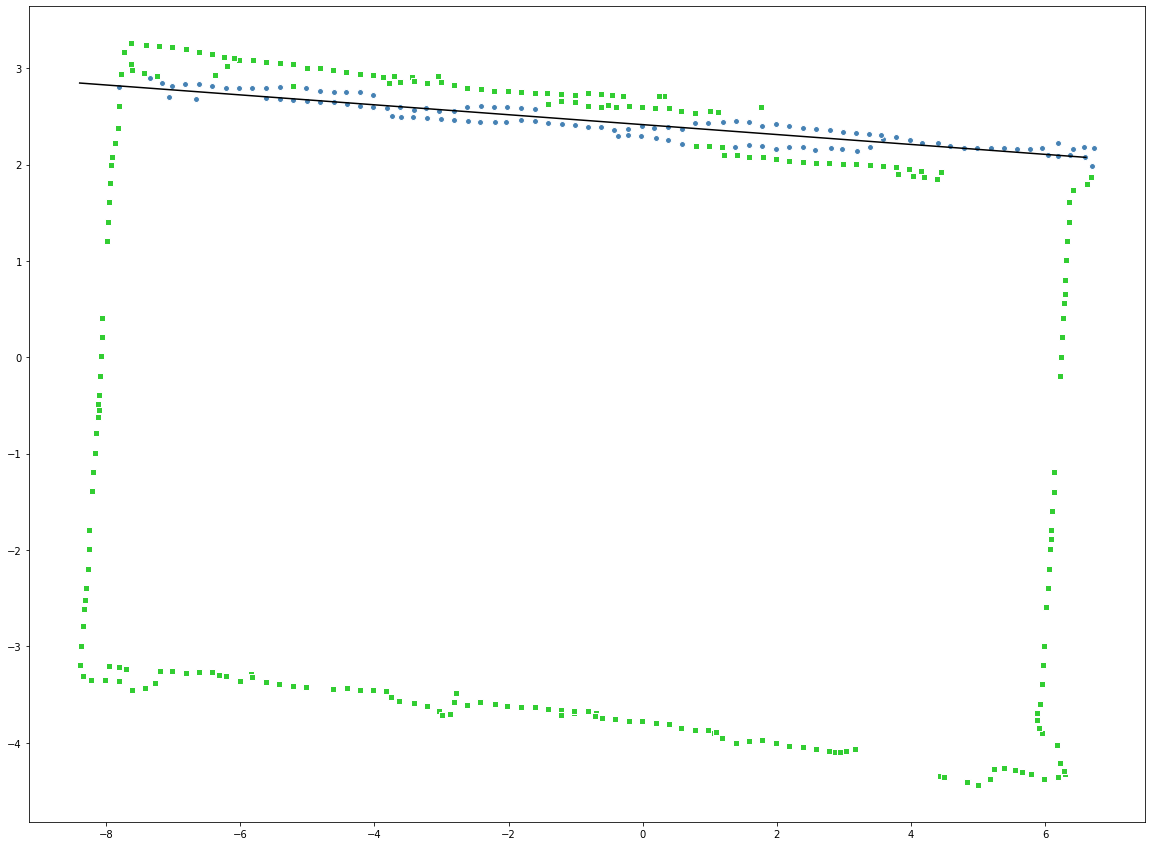

In [24]:
# Take inspiration from above to broaden use cases, but for now not necessary. Use this to find the angle to know what to rotate the points with
def findAng(theta):
    if theta > 1.57:
        theta = abs(1.57 - theta)
    else:
        theta = abs(theta - 1.57)
    return theta

x = pts[:,0].reshape(-1, 1)
y = pts[:,1]

slope = FindSlope(x, y)
print('Slope of line: ', slope)
angle = np.arctan(slope)
print(angle)
angle = findAng(angle)
print('Angle: ', angle)



In [25]:

def rotate(origin, point, angle):
    origin_x, origin_y = origin 
    
    px, py = point
    
    qx = origin_x + math.cos(angle) * (px - origin_x) - math.sin(angle) * (py - origin_y)
    qy = origin_y + math.sin(angle) * (px - origin_x) + math.cos(angle) * (py - origin_y)

    return qx, qy


def rotatingPoints(points, angle):
    origin = (5, 5)
    rotPts = []
    for point in points:
        newPts = rotate(origin, point, angle)
        rotPts.append(newPts)
    
    rotPts = np.array(rotPts)
    return rotPts

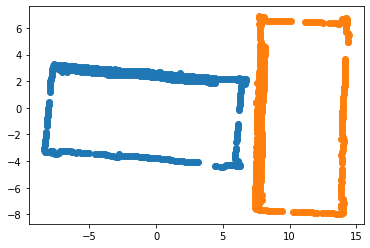

In [26]:
pts = np.delete(pGen, 1, 1)
rotPts = rotatingPoints(pts, angle)
x = rotPts[:,0]
y = rotPts[:,1]

d = pts[:,0]
j = pts[:,1]

plt.scatter(d, j)
plt.scatter(x, y)
plt.show()

In [18]:
def boxGen(points):  
    minPx = min(points[:,0])
    minPy = min(points[:,1])
    maxPx = max(points[:,0])
    maxPy = max(points[:,1])
    
    startPoint = [minPx, minPy]
    MaxSize = [maxPx, maxPy]
    #Find a starting point and opposite corner point starting with a minimum 1 meter square
    oppPoint = [startPoint[0]+1, startPoint[1]+1]
    
    maxList = []
    
    coords = [0, 0]
    preVal = []
    Inliers = 0
    Outliers = 0
    largest = 0
    outPoints = []
    outlierPoints = []
    inlierPoints = []
    
    inPoints = []
    
    while oppPoint[0] <= MaxSize[0]:
        
        
        for point in points:
            checkPoint = solve(startPoint, oppPoint, point)
            if checkPoint == True:
                Inliers += 1    
                inlierPoints.append(point)
            else:
                Outliers += 1
                outlierPoints.append(point)
        
        
        preVal.append(Inliers)
        oppPoint[0] += 0.1 

        print("Current inliers: ", Inliers)
        currV = Inliers
        Inliers = 0
        inlierPoints.clear()
        outlierPoints.clear()
        
    #Move the y-axis a little before starting the iteration there in order to avoid getting the same value for the start of the next one
    oppPoint[1] += 0.1
    
    preVal = []
    while oppPoint[1] <= MaxSize[1]:
        for point in points:
            checkPoint = solve(startPoint, oppPoint, point)
            if checkPoint == True:
                Inliers += 1
                inlierPoints.append(point)
            else:
                Outliers += 1
                outlierPoints.append(point)
        
        preVal.append(Inliers)
        maxList.append(preVal)
       
        oppPoint[1] += 0.1 
        
        print("Current inliers: ", Inliers, '\n')
        currV = Inliers
        
        max_value = max(maxList)
        max_index = maxList.index(max_value)
        
        if max(maxList[max_index]) > largest:
            largest = max(maxList[max_index])
            print("largest", largest)
            coords[0] = oppPoint[0]
            coords[1] = oppPoint[1]
            print("total points", len(points))
            print("total inliers", len(inlierPoints))
            storeLargest(largest, coords, inlierPoints)
            
            if len(inlierPoints) == largest:
                inPoints.append(inlierPoints)
                print(inPoints)
                
                #inPoints = inlierPoints
                print("test len", len(inPoints))
                
   


            
        Inliers = 0
        
        inlierPoints.clear()
        outlierPoints.clear()
        #outlierPoints.clear()
        
    return startPoint, coords
    
#print(largest)


startPos, endPos = boxGen(rotPts) ### Kommenterer det her ud ved første start og så kør celle 8 igen med angle, så kan den her køre

#print(startPos, endPos) ### Samme her 

Current inliers:  21
Current inliers:  21
Current inliers:  22
Current inliers:  22
Current inliers:  23
Current inliers:  23
Current inliers:  24
Current inliers:  24
Current inliers:  25
Current inliers:  25
Current inliers:  25
Current inliers:  25
Current inliers:  25
Current inliers:  25
Current inliers:  25
Current inliers:  25
Current inliers:  26
Current inliers:  26
Current inliers:  27
Current inliers:  27
Current inliers:  28
Current inliers:  28
Current inliers:  29
Current inliers:  29
Current inliers:  30
Current inliers:  31
Current inliers:  33
Current inliers:  33
Current inliers:  34
Current inliers:  34
Current inliers:  35
Current inliers:  35
Current inliers:  36
Current inliers:  36
Current inliers:  37
Current inliers:  37
Current inliers:  37
Current inliers:  37
Current inliers:  38
Current inliers:  38
Current inliers:  39
Current inliers:  39
Current inliers:  40
Current inliers:  40
Current inliers:  41
Current inliers:  41
Current inliers:  43
Current inlie

NameError: name 'storeLargest' is not defined

In [17]:
def removeInliers(startPos, endPos, rotPts):

    newPointCloud = []
    
    for point in rotPts:
        checkPoint = solve(startPos, endPos, point)   
        if checkPoint == False:
            newPointCloud.append(point)
        
    return np.asarray(newPointCloud)
                
newPointCloud = removeInliers(startPos, endPos, rotPts)

d = newPointCloud[:,0]
j = newPointCloud[:,1]
plt.scatter(d,j)


NameError: name 'startPos' is not defined

In [ ]:
from matplotlib.pyplot import figure
def DrawFloorPlan(x1, y1, x2, y2):
    
    plt.axes()
    rectangle = plt.Rectangle((x1, y1), abs(x1 - x2), abs(y1 - y2), fc='none',ec="red")
    plt.gca().add_patch(rectangle)
    x = rotPts[:,0]
    y = rotPts[:,1]
    plt.scatter(x,y)
    #plt.axis('scaled')
    plt.show()

In [ ]:
DrawFloorPlan(startPos[0], startPos[1], endPos[0], endPos[1])

In [ ]:
def storeLargest(largest, coords, inlierPoints):  
    print("")
    print("Now in storeLargest function")
    print("Largest", largest)
    print("coords", coords)
    #print("Inlier points", len(inlierPoints) , '\n')
        

    return largest, coords, inlierPoints

In [ ]:
x = np.arange(10)
y = np.random.rand(10)

plt.xticks(range(min(valueX), max(valueX)+1))

plt.figure(figsize=(10, 10), dpi=100)
plt.scatter(x, y)